In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import cv2
import os

In [3]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import *
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau
from keras.layers.merge import concatenate

C:\Users\Ali\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
# Define path of data to be used for preprocessing and training
path = "./all/"

# Preprocessing

In [5]:
# Load images, define path to original dataset provided
images_tr = np.load(path + 'train_images.npy', encoding="latin1")
images = np.load(path + 'test_images.npy', encoding="latin1")
labels = pd.read_csv(path + 'train_labels.csv')
labels = labels['Category'].values
images.shape

(10000, 2)

In [6]:
# Several helper functions
def crop_img(img, square_size = 40):
    img = np.uint8(img)
    x_vals, y_vals, temp_length, temp_height = get_box_size(img)
    img =  img[y_vals[1]:y_vals[1]+temp_height + 1, x_vals[0]:x_vals[0]+temp_length + 1]
    return img

def preProcessImage(image, num_contours = 1, cutoff=200):
    image = np.uint8(image)
    im = np.uint8(image)
    red, thresh = cv2.threshold(im, cutoff, 255, 0)
    im2, contours, hierarchy= cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros(im.shape, np.uint8)
    largest_contours = sorted(contours, key=cv2.contourArea, reverse=True)

    for ind, contour in enumerate(largest_contours[:num_contours]):
        x, y, w, h = cv2.boundingRect(contour)
        mask[y:y+h, x:x+w] = 255
        
    filteredImage = cv2.bitwise_and(thresh, thresh, mask=mask)
    return filteredImage.reshape((image.shape))

def square_up(img):
    x_vals, y_vals, temp_length, temp_height = get_box_size(img)
    if temp_length > temp_height:
        diff = temp_length - temp_height
        img = cv2.copyMakeBorder(img, diff//2, diff//2,0, 0,cv2.BORDER_CONSTANT,value = 0)
    else:
        diff = temp_height - temp_length
        img = cv2.copyMakeBorder(img, 0, 0, diff//2, diff//2,cv2.BORDER_CONSTANT,value = 0)
        
    return img

def get_box_size(img):
    data = np.uint8(img)
    x_min = 100
    y_min = 0
    x_max = 0
    y_max = 100
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if data[i][j] != 0:
                x_min = min(x_min, j)
                x_max = max(x_max, j)
                y_max = min(y_max, i)
                y_min = max(y_min, i)
    total_width = x_max - x_min
    total_height = y_min - y_max
    return (x_min, x_max), (y_min, y_max), total_width, total_height

In [21]:
def pipeline(features_path, labels_path):
    images = np.load(features_path, encoding="latin1")
    labels = pd.read_csv(labels_path)['Category'].values
    features = []
    for i in range(len(labels)):
        img = preProcessImage(images[i][1].reshape(100, 100), 1, 150)
        img = crop_img(img)
        img = square_up(img)
        img = cv2.resize(img, (40, 40))
        img = np.pad(img, pad_width=1, mode="constant", constant_values=0)
        features.append(img)
    return np.array(features)

  
train_features_path = path + 'train_images.npy'
labels_path = path + 'train_labels.csv'

train_features = pipeline(train_features_path, labels_path)
np.save(path + 'processed_resized_train_images.npy', train_features)

test_features_path = path + 'test_images.npy'
test_features = pipeline(test_features_path, labels_path)
np.save(path + 'processed_resized_test_images.npy', test_features)

# Model Definition

In [41]:
modelVgg = keras.applications.vgg16.VGG16(include_top=False, input_shape=(42, 42, 3), classes=31)    
modelDense = keras.applications.densenet.DenseNet121(include_top=False, input_shape=(42, 42, 3), classes=31)    

#### **VGG16 Model**

In [45]:
vgg_model = Sequential()
for layer in modelVgg.layers:
    vgg_model.add(layer)
vgg_model.add(Flatten())
vgg_model.add(Dense(31, name='LinearCombination'))
vgg_model.add(Activation('softmax'))

#### **DenseNet121 Model**

In [25]:
densenet_model = Sequential()
densenet_model.add(modelDense)
densenet_model.add(Flatten())
densenet_model.add(Dense(31, name='LinearCombination'))
densenet_model.add(Activation('softmax'))

#### **MNIST CNN, layers added:**

In [26]:
mnist_model = Sequential()

mnist_model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (42,42,3)))
mnist_model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
mnist_model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
mnist_model.add(MaxPool2D(pool_size=(2,2)))


mnist_model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
mnist_model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
mnist_model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
mnist_model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))


mnist_model.add(Flatten())
mnist_model.add(Dense(256, activation = "relu"))
mnist_model.add(Dense(31, activation = "softmax"))

# Processing/Set up

#### Load Images

In [27]:
images = np.load(path + "processed_resized_train_images.npy", encoding = 'latin1')

In [28]:
labels = pd.read_csv(path + "train_labels.csv")["Category"].values
labels

array(['shovel', 'rifle', 'scorpion', ..., 'rollerskates', 'mouth',
       'pencil'], dtype=object)

In [29]:
train_img = []
for i, img in enumerate(images):
    train_img.append(np.repeat(np.reshape(img, (42, 42))[:, :, np.newaxis], repeats=3, axis=2))
train_img = np.array(train_img)

#### One Hot Encoding/Split Data

In [30]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

In [31]:
le = LabelEncoder()
y = to_categorical(le.fit_transform(labels), num_classes = 31)
print("Y: ", y)
print("y.shape: ", y.shape)

# Set the random seed
random_seed = 69

# Split the train and the validation set for the fitting
x_train, x_val, y_train, y_val = train_test_split(train_img, y, test_size = 0.1, random_state=random_seed)

Y:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
y.shape:  (10000, 31)


In [43]:
# my_model.load_weights("../content/gdrive/My Drive/Academic/COMP 551/Kaggle Project/Data/Weights/vgg16_kaggle_train.h5")

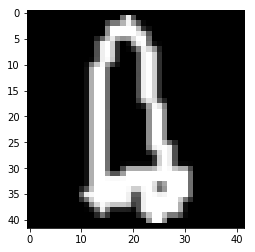

C:\Users\Ali\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


'penguin'

In [39]:
i = 9
plt.imshow(x_train[i].reshape(42, 42, 3), cmap="gray")
plt.show()

le.inverse_transform(np.argmax(y_train[i]))

# Training

In [18]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.000001)

In [46]:
# Select the model you want to run: vgg_model, mnist_model, densenet_model

my_model = vgg_model

# Set all layers to be trainable
for layer in my_model.layers:
    layer.trainable = True

# my_model.compile(optimizers.SGD(lr=0.00001, momentum=0.01, decay=0.0, nesterov=False), 
#                  loss="categorical_crossentropy", 
#                  metrics=["accuracy"])    

# my_model.compile(optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0), 
#                  loss="categorical_crossentropy", 
#                  metrics=["accuracy"])   

my_model.compile(optimizers.Adam(lr=0.00001), 
                 loss="categorical_crossentropy", 
                 metrics=["accuracy"])    

my_model.summary()
  
history = my_model.fit(x_train, y_train, batch_size=32,
             epochs = 50,
             validation_data = (x_val,y_val), callbacks=[learning_rate_reduction])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 42, 42, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 42, 42, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 21, 21, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 21, 21, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 21, 21, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 10, 10, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 10, 10, 256)       295168    
__________

# Plots

In [47]:
import pickle

#### Save training history:

In [49]:
with open(path+'/VGG16_HoG73val', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
    
hist = pickle.load(open(path+'/VGG16_HoG73val', 'rb'))
my_model.save(path + "VGG16_HoG73val.h5")

In [50]:
def top_five_val(vals):
    vals = vals["val_acc"]
    top_5_vals = sorted(vals, reverse=True)[:5]
    return sum(top_5_vals)/5.0

In [51]:
top_five_val(hist)

0.7290000000000001

#### Plots

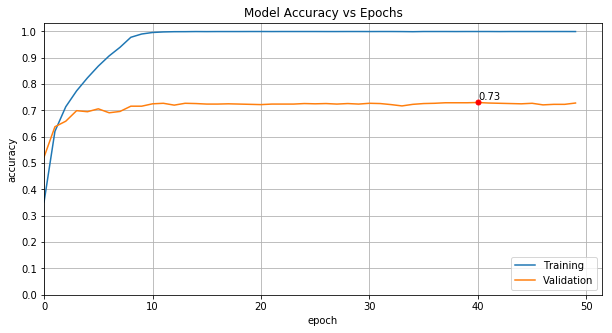

In [52]:
max_val = max(hist["val_acc"])
max_ind = hist["val_acc"].index(max_val)
plt.figure(figsize=(10,5))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.plot(max_ind, max_val, 'o', color="red", markersize=5)
plt.annotate(str(max_val), (max_ind, max_val+0.01), fontsize=10)
plt.title("Model Accuracy vs Epochs")
plt.xlabel("epoch")
plt.yticks(np.arange(0, 1.0 + 0.01, 0.1))

plt.ylabel("accuracy")
plt.grid(True)
plt.legend(["Training", "Validation"], loc="lower right")
plt.xlim(left=0)
plt.show()

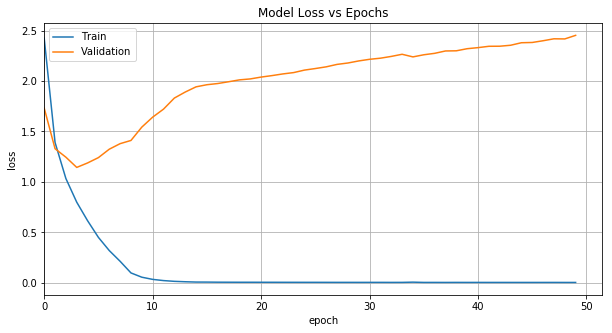

In [53]:
max_val = max(hist["val_loss"])
max_ind = hist["val_loss"].index(max_val)
plt.figure(figsize=(10,5))
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.title("Model Loss vs Epochs")
plt.xlabel("epoch")

plt.ylabel("loss")
plt.grid(True)
plt.legend(["Train", "Validation"], loc="upper left")
plt.xlim(left=0)
plt.show()

# Predictions

In [55]:
# Load test images
tr_images = np.load(path + "processed_resized_test_images.npy", encoding = 'latin1')
test_img = []
for i, img in enumerate(tr_images):
    test_img.append(np.repeat(np.reshape(img, (42, 42))[:, :, np.newaxis], repeats=3, axis=2))
test_img = np.array(test_img)

In [56]:
# Get model predictions
test_pred = my_model.predict(test_img)

In [57]:
def one_hot(x):
    a = np.zeros(x.shape)
    a[np.argmax(x)] = 1
    return a

In [58]:
test = []
for pred in test_pred:
    test.append(one_hot(pred))

test = np.array(test)

In [59]:
%%capture --no-stdout
sub_pred = []
for pred in test:
    sub_pred.append(le.inverse_transform(np.argmax(pred)))

In [60]:
df = pd.DataFrame({"Id": np.arange(len(sub_pred)), "Category": sub_pred})
df = df[["Id", "Category"]]

In [61]:
df

,Id,Category
0,0,pineapple
1,1,pear
2,2,mug
3,3,pool
4,4,empty
5,5,rifle
6,6,pool
7,7,scorpion
8,8,pineapple
9,9,rollerskates


In [62]:
# Save file to CSV
df.to_csv(path + "vgg16_86_imagegen.csv", index=False)